In [1]:
import random
import hashlib as hasher

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            if creator != None:
                self.creator = Miner(0 , creator.networkingPower, creator.miner_type ,"0")
            else:
                self.creator = Miner(0 , None, None, "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self, miner_networking_power, miner_type):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        new_maxes = []
        if len(maxes) > 1:
            chances = list(range(1, 101, 1))
            choice = random.choice(chances)
            for block in maxes:
                """
                if choice <= miner_networking_power and miner_type == block.creator.miner_type:
                    # Miner type(honest/selfish) wins, the other type(honest/selfish) loses
                    new_maxes.append(block)
                elif choice > miner_networking_power and miner_type != block.creator.miner_type:
                    # Miner type(honest/selfish) loses, the other type(honest/selfish) wins
                    new_maxes.append(block)
                """
                creator_networking_power = block.creator.networkingPower
                if choice <= creator_networking_power:
                    # Miner type(honest/selfish) wins, the other type(honest/selfish) loses
                    new_maxes.append(block)
        else:
            new_maxes = maxes
            
        if len(new_maxes) == 0:
            new_maxes = maxes
        return new_maxes[0]
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last = self.longestChain(miner.networkingPower, miner.miner_type)
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        self.miningPower = miningPower
        self.networkingPower = networkingPower
        self.miner_type = miner_type
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain(self.networkingPower, self.miner_type)
  
    def UpdateLast(self):
        latest = self.blockchain.longestChain(self.networkingPower, self.miner_type)
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        super().__init__(miningPower, networkingPower, miner_type, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain(self.networkingPower, self.miner_type)
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

In [2]:
def make_miners(type_of_minors, networking_power, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, networking_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, networking_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

def simulate_selfish_mining(bc, legal_miners, selfish_miners):
    run_to = 101
    while bc.size < run_to:
        for s in selfish_miners:
            s.PoWSolver()

        for m in legal_miners:
            m.PoWSolver()

        for s in selfish_miners:
            s.UpdateLast()

        for m in legal_miners:
            m.UpdateLast()
    
    selfish_profit = 0
    for miner in selfish_miners:
        bc_height = bc.longestChain(miner.networkingPower, miner.miner_type).height
        percentage_of_miner_blocks = bc.checkMiner(miner) / bc_height
        selfish_profit += percentage_of_miner_blocks
    
    honest_profit = 0
    for miner in legal_miners:
        bc_height = bc.longestChain(miner.networkingPower, miner.miner_type).height
        percentage_of_miner_blocks = bc.checkMiner(miner) / bc_height
        honest_profit += percentage_of_miner_blocks
        
    return selfish_profit, honest_profit

In [3]:
### The effect of network power on selfish mining
### Modelling 50 honest miners and 50 selfish miner, each with 50% of total mining power

output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for i in sim_range_selfish:
    num_of_selfish_miners = 50
    num_of_honest_miners = 50
    
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    selfish_networking_power = i
    honest_networking_power = 100-i
    
    bc = Blockchain("0" , 11)
    
    honest_miners = make_miners("honest", honest_networking_power, num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", selfish_networking_power, num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation of networking power with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_networking_power}% of total networking power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_networking_power}% of total networking power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()
    

Running simulation of networking power with:
-> 50 honest minors having 100% of total networking power
-> 50 selfish minors having 0% of total networking power
...
Honest profit: 0.8431372549019612
Selfish profit: 0.1568627450980392
Total profit: 1.0000000000000004

Running simulation of networking power with:
-> 50 honest minors having 99% of total networking power
-> 50 selfish minors having 1% of total networking power
...
Honest profit: 0.9607843137254902
Selfish profit: 0.0392156862745098
Total profit: 1.0

Running simulation of networking power with:
-> 50 honest minors having 98% of total networking power
-> 50 selfish minors having 2% of total networking power
...
Honest profit: 0.8888888888888886
Selfish profit: 0.1111111111111111
Total profit: 0.9999999999999998

Running simulation of networking power with:
-> 50 honest minors having 97% of total networking power
-> 50 selfish minors having 3% of total networking power
...
Honest profit: 0.86046511627907
Selfish profit: 0.139

Honest profit: 0.8983050847457628
Selfish profit: 0.1016949152542373
Total profit: 1.0

Running simulation of networking power with:
-> 50 honest minors having 68% of total networking power
-> 50 selfish minors having 32% of total networking power
...
Honest profit: 0.9615384615384617
Selfish profit: 0.038461538461538464
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 50 honest minors having 67% of total networking power
-> 50 selfish minors having 33% of total networking power
...
Honest profit: 0.9038461538461541
Selfish profit: 0.09615384615384616
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 50 honest minors having 66% of total networking power
-> 50 selfish minors having 34% of total networking power
...
Honest profit: 0.8181818181818183
Selfish profit: 0.18181818181818182
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 50 honest minors having 65% of total networking power
-> 50

Honest profit: 0.862745098039216
Selfish profit: 0.11764705882352941
Total profit: 0.9803921568627454

Running simulation of networking power with:
-> 50 honest minors having 36% of total networking power
-> 50 selfish minors having 64% of total networking power
...
Honest profit: 0.8571428571428574
Selfish profit: 0.14285714285714285
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 50 honest minors having 35% of total networking power
-> 50 selfish minors having 65% of total networking power
...
Honest profit: 0.7735849056603773
Selfish profit: 0.22641509433962265
Total profit: 1.0

Running simulation of networking power with:
-> 50 honest minors having 34% of total networking power
-> 50 selfish minors having 66% of total networking power
...
Honest profit: 0.8000000000000002
Selfish profit: 0.2
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 50 honest minors having 33% of total networking power
-> 50 selfish minors h

Honest profit: 0.6111111111111108
Selfish profit: 0.38888888888888873
Total profit: 0.9999999999999996

Running simulation of networking power with:
-> 50 honest minors having 4% of total networking power
-> 50 selfish minors having 96% of total networking power
...
Honest profit: 0.6818181818181815
Selfish profit: 0.3181818181818181
Total profit: 0.9999999999999997

Running simulation of networking power with:
-> 50 honest minors having 3% of total networking power
-> 50 selfish minors having 97% of total networking power
...
Honest profit: 0.6037735849056604
Selfish profit: 0.3962264150943396
Total profit: 1.0

Running simulation of networking power with:
-> 50 honest minors having 2% of total networking power
-> 50 selfish minors having 98% of total networking power
...
Honest profit: 0.5306122448979593
Selfish profit: 0.4693877551020409
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 50 honest minors having 1% of total networking power
-> 50 selfis

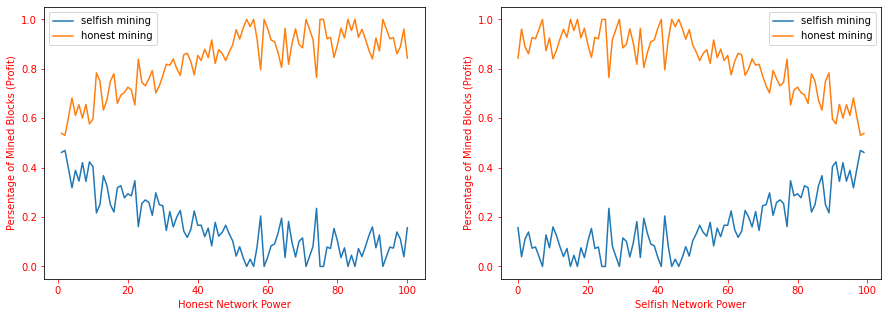

In [4]:
import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Honest Network Power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Selfish Network Power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[1].legend()

You may want to address some of the limitations though:

1- What if we have more than 1 correct fork (For example we have 3 blocks as the max height, 1 for selfish, 2 for others).
-> all blocks will still have some chances of being selected, but the type of the block creator with higher networking power have higher chances as we pick a random number from 1 to 100 and if this random number is smaller or equal than the networking power of the miner then the blocks created by miners who shares his type is selected, if not than the other blocks is selected, the type can be either selfish mined blocks or honest mined blocks.

2- What if we have more than 1 selfish miners with different networking power?
3- Can we have different networking power for all miners?
4- Have some other diagrams for showing the impact of both network and mining power

In [5]:
# 2- What if we have more than 1 selfish miners with different networking power?
# 3- Can we have different networking power for all miners?

def make_miners_with_varying_network_power(type_of_minors, total_network_power, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    remaining_network_power = total_network_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
            network_power = remaining_network_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            
            if remaining_network_power != 0:
                possible_network_power = list(range(1, remaining_network_power+1, 1))
                network_power = random.choice(possible_network_power)
                remaining_network_power -= network_power
            else:
                network_power = 0
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, network_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

print("Simulating varying network power between miners with")
print("-> equal mining power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    
    total_mining_power = 100
    honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
    selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
    honest_mining_power = round(total_mining_power * honest_mining_power_share)
    selfish_mining_power = round(total_mining_power * selfish_mining_power_share)
    
    total_network_power = 100
    honest_network_power_share = round(num_of_honest_miners/total_network_power, 2)
    selfish_network_power_share = round(num_of_selfish_miners/total_network_power, 2)
    honest_network_power = round(total_network_power * honest_network_power_share)
    selfish_network_power = round(total_network_power * selfish_network_power_share)

    bc = Blockchain("0" , 11)
    
    honest_miners = make_miners_with_varying_network_power("honest", honest_network_power, num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners_with_varying_network_power("selfish", selfish_network_power, num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_network_power}% of total networking power and {honest_mining_power}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_network_power}% of total networking power and {selfish_mining_power}% of total mining power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {round(selfish_profit+honest_profit)}")
        print()
    

Simulating varying network power between miners with
-> equal mining power for each miner
-> and varying the number of honest and selfish miners at each simulation

Running simulation with:
-> 100 honest minors having 100% of total networking power and 100% of total mining power
-> 0 selfish minors having 0% of total networking power and 0% of total mining power
...
Honest profit: 1.0000000000000004
Selfish profit: 0
Total profit: 1

Running simulation with:
-> 99 honest minors having 99% of total networking power and 99% of total mining power
-> 1 selfish minors having 1% of total networking power and 1% of total mining power
...
Honest profit: 0.9999999999999999
Selfish profit: 0.0
Total profit: 1

Running simulation with:
-> 98 honest minors having 98% of total networking power and 98% of total mining power
-> 2 selfish minors having 2% of total networking power and 2% of total mining power
...
Honest profit: 1.0000000000000007
Selfish profit: 0.0
Total profit: 1

Running simulation

Honest profit: 0.9393939393939389
Selfish profit: 0.06060606060606061
Total profit: 1

Running simulation with:
-> 70 honest minors having 70% of total networking power and 70% of total mining power
-> 30 selfish minors having 30% of total networking power and 30% of total mining power
...
Honest profit: 0.9466666666666659
Selfish profit: 0.05333333333333334
Total profit: 1

Running simulation with:
-> 69 honest minors having 69% of total networking power and 69% of total mining power
-> 31 selfish minors having 31% of total networking power and 31% of total mining power
...
Honest profit: 0.9999999999999997
Selfish profit: 0.0
Total profit: 1

Running simulation with:
-> 68 honest minors having 68% of total networking power and 68% of total mining power
-> 32 selfish minors having 32% of total networking power and 32% of total mining power
...
Honest profit: 0.9402985074626865
Selfish profit: 0.05970149253731343
Total profit: 1

Running simulation with:
-> 67 honest minors having 67% 

Honest profit: 0.8723404255319148
Selfish profit: 0.1276595744680851
Total profit: 1

Running simulation with:
-> 41 honest minors having 41% of total networking power and 41% of total mining power
-> 59 selfish minors having 59% of total networking power and 59% of total mining power
...
Honest profit: 0.8979591836734697
Selfish profit: 0.10204081632653061
Total profit: 1

Running simulation with:
-> 40 honest minors having 40% of total networking power and 40% of total mining power
-> 60 selfish minors having 60% of total networking power and 60% of total mining power
...
Honest profit: 0.9583333333333334
Selfish profit: 0.041666666666666664
Total profit: 1

Running simulation with:
-> 39 honest minors having 39% of total networking power and 39% of total mining power
-> 61 selfish minors having 61% of total networking power and 61% of total mining power
...
Honest profit: 0.8717948717948721
Selfish profit: 0.1282051282051282
Total profit: 1

Running simulation with:
-> 38 honest min

Honest profit: 0.5357142857142856
Selfish profit: 0.4642857142857142
Total profit: 1

Running simulation with:
-> 12 honest minors having 12% of total networking power and 12% of total mining power
-> 88 selfish minors having 88% of total networking power and 88% of total mining power
...
Honest profit: 0.5833333333333334
Selfish profit: 0.41666666666666663
Total profit: 1

Running simulation with:
-> 11 honest minors having 11% of total networking power and 11% of total mining power
-> 89 selfish minors having 89% of total networking power and 89% of total mining power
...
Honest profit: 0.4444444444444444
Selfish profit: 0.5555555555555556
Total profit: 1

Running simulation with:
-> 10 honest minors having 10% of total networking power and 10% of total mining power
-> 90 selfish minors having 90% of total networking power and 90% of total mining power
...
Honest profit: 0.4166666666666667
Selfish profit: 0.5833333333333333
Total profit: 1

Running simulation with:
-> 9 honest minors

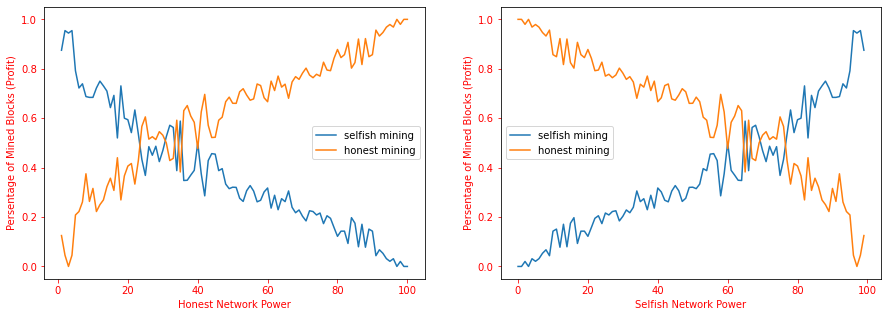

In [6]:
import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Honest Network Power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Selfish Network Power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[1].legend()